# EXERCICE: FEDERATED LEARNING APPLIED TO THE MNIST DATASET
## Safety, Privacy and Legal Aspects
#### Name: .Johana Cómbita Niño..

In [1]:
import numpy as np
import tensorflow as tf
import keras

from keras.datasets import mnist
from tensorflow import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import load_model

Primero se carga el conjunto de datos MNIST, se preparan los datos y se visualizan para explorar el dataset.

In [2]:
# Read the MNIST data and process it. You can use reshape form numpy and to_categorical from 
# tensorflow.keras.utils
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
np.shape(x_train)

(60000, 28, 28)

In [3]:
# reshape the data
# Normalizar las imágenes al rango [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
np.shape(x_train)

(60000, 28, 28, 1)

In [4]:
# one hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

y_train [0:5,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

c:\Users\Johana Combita\.conda\envs\tensorflow\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


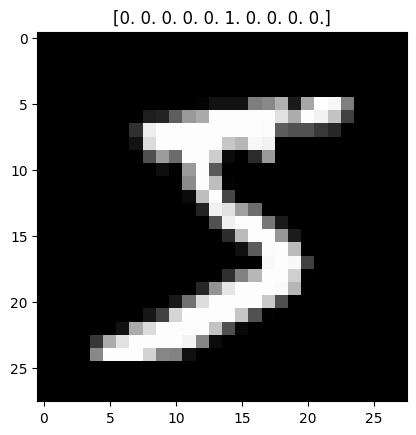

In [5]:
# To familiarize yourself with the data, you can display some of the images and their corresponding labels,
# and view their dimensions

plt.imshow(x_train[0].reshape(28,28), cmap='gray')
plt.title(y_train[0])
plt.show()

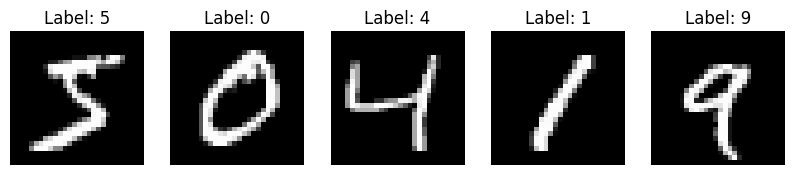

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


In [6]:
#imagenes con sus etiquetas
num_images = 5 
plt.figure(figsize=(10, 2))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap="gray")
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis("off")

plt.show()

# Ver las dimensiones de los datos
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

Se crean 3 clientes a partir de los datos de Train con diferente cantidad de datos para cada uno.

In [7]:
# Create 3 clients from the train data with different amount of data. 
# You can do it as you prefer, either using slices (e.g. client1_x = X_train[:len(X_train)//3]), 
# creating a function that makes it automatic according to the number of clients desired 
# (remember that two different clients cannot have data in common), or any other way you can think of.
#Nota: tamaño de los clientes no puede ser el mismo, porque mas adelante hare una media ponderada

# Definir proporciones diferentes para cada cliente
P_client1 = 0.5
P_client2 = 0.3
P_client3 = 1 - P_client1 - P_client2
total_samples = x_train.shape[0]
client1_size = int(P_client1 * total_samples)  
client2_size = int(P_client2 * total_samples)
client3_size = int(P_client3 * total_samples)

print(client1_size, client2_size, client3_size)

30000 18000 12000


In [8]:
# Asignar los datos a cada cliente
client1_x, client1_y = x_train[:client1_size], y_train[:client1_size]
client2_x, client2_y = x_train[client1_size:client1_size + client2_size], y_train[client1_size:client1_size + client2_size]
client3_x, client3_y = x_train[client1_size + client2_size:], y_train[client1_size + client2_size:]

#dimensiones de los subconjuntos
print(f"Cliente 1: {client1_x.shape}, {client1_y.shape}")
print(f"Cliente 2: {client2_x.shape}, {client2_y.shape}")
print(f"Cliente 3: {client3_x.shape}, {client3_y.shape}")


Cliente 1: (30000, 28, 28, 1), (30000, 10)
Cliente 2: (18000, 28, 28, 1), (18000, 10)
Cliente 3: (12000, 28, 28, 1), (12000, 10)


In [9]:
print(f'''Number of data for each client: \n \t Client 1: {len(client1_x)}
     \t Client 2: {len(client2_x)} \n \t Client 3: {len(client3_x)}''')

Number of data for each client: 
 	 Client 1: 30000
     	 Client 2: 18000 
 	 Client 3: 12000


In [11]:
# Check that the clients have been created correctly (that there is the same number of data in X_train as adding
# up all clients)
assert sum([len(client1_x), len(client2_x), len(client3_x)]) == len(x_train), 'Clients have not been created correctly'

Luego se crea el modelo de red neuronal.

In [12]:
# Crear el modelo
model = Sequential()

# Primera capa convolucional 
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))  

# Segunda capa convolucional 
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Aplanar la salida de las capas convolucionales
model.add(Flatten())

# Capa completamente conectada
model.add(Dense(128, activation='relu'))

# Capa de salida con 10 neuronas 
model.add(Dense(10, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Mostrar la estructura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

Con el modelo listo y antes de hacer el entrenamiento con cada cliente, es necesario guardar los pesos iniciales del modelo, los cuales representan el estado inicial del modelo antes de ser entrenado con los datos de los clientes. Luego se continua con el entrenamiento por cada cliente 3 veces (entrenamiento federado). En cada ronda, los 3 clientes entrenan el modelo independientemente, y sus pesos se agregan al modelo teniendo en cuenta el promedio ponderado. Luego el modelo actualizado se usa en la siguiente ronda. Al final de las 3 rondas, se tiene un modelo que ha aprendido a partir de los datos de todos los clientes de manera federada.

In [13]:
# Get the initial weights:
# Obtener los pesos iniciales del modelo
i_weights = model.get_weights()

#funcion para ponderar los pesos
def weighted_average(w_list, sizes):
    avg_weights = []
    
    # Promediar los pesos
    for w in zip(*w_list): 
        weighted = np.average(w, axis=0, weights=sizes)
        avg_weights.append(weighted)
    
    return avg_weights

In [14]:
N = 3
c_weights = i_weights

#Entrenamiento de los clientes
for i in range(N):
    print(f"Entrenamiento {i+1}")
    # Primer cliente
    model.set_weights(c_weights)
    model.fit(client1_x, client1_y, epochs=5, batch_size=32)
    w_client1 = model.get_weights()

    # Segundo cliente
    model.set_weights(c_weights)
    model.fit(client2_x, client2_y, epochs=5, batch_size=32)
    w_client2 = model.get_weights()

    # Tercer cliente
    model.set_weights(c_weights)
    model.fit(client3_x, client3_y, epochs=5, batch_size=32)
    w_client3 = model.get_weights()

    #Ponderar los pesos
    c_weights = weighted_average([w_client1, w_client2, w_client3], [client1_size, client2_size, client3_size])
    
    # Asignación de los pesos promedio al modelo
    model.set_weights(c_weights)
    
    #Guardar el modelo
    model.save(f'model_federated_{i}.h5')

#Guardar el modelo final
model.save('model_federated.h5')
print("Modelo guardado")


Entrenamiento 1
Epoch 1/5
938/938 [==============================] - 20s 20ms/step - loss: 0.1821 - accuracy: 0.9430
Epoch 2/5
938/938 [==============================] - 24s 25ms/step - loss: 0.0553 - accuracy: 0.9830
Epoch 3/5
938/938 [==============================] - 22s 23ms/step - loss: 0.0360 - accuracy: 0.9881
Epoch 4/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0263 - accuracy: 0.9917
Epoch 5/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0187 - accuracy: 0.9944
Epoch 1/5
563/563 [==============================] - 11s 19ms/step - loss: 0.2591 - accuracy: 0.9184
Epoch 2/5
563/563 [==============================] - 11s 20ms/step - loss: 0.0787 - accuracy: 0.9752
Epoch 3/5
563/563 [==============================] - 15s 26ms/step - loss: 0.0515 - accuracy: 0.9830
Epoch 4/5
563/563 [==============================] - 14s 25ms/step - loss: 0.0342 - accuracy: 0.9889
Epoch 5/5
563/563 [==============================] - 13s 24ms/step - loss: 

c:\Users\Johana Combita\.conda\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


938/938 [==============================] - 19s 21ms/step - loss: 0.0309 - accuracy: 0.9903
Epoch 2/5
938/938 [==============================] - 18s 20ms/step - loss: 0.0192 - accuracy: 0.9941
Epoch 3/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0137 - accuracy: 0.9961
Epoch 4/5
938/938 [==============================] - 20s 21ms/step - loss: 0.0106 - accuracy: 0.9967
Epoch 5/5
938/938 [==============================] - 25s 26ms/step - loss: 0.0071 - accuracy: 0.9977
Epoch 1/5
563/563 [==============================] - 15s 26ms/step - loss: 0.0453 - accuracy: 0.9862
Epoch 2/5
563/563 [==============================] - 13s 24ms/step - loss: 0.0283 - accuracy: 0.9917
Epoch 3/5
563/563 [==============================] - 15s 27ms/step - loss: 0.0181 - accuracy: 0.9942
Epoch 4/5
563/563 [==============================] - 12s 20ms/step - loss: 0.0124 - accuracy: 0.9959
Epoch 5/5
563/563 [==============================] - 11s 19ms/step - loss: 0.0089 - accuracy: 0.9970


**HINT**: some functions you need to know: set_weights, get_weights. Create an auxiliary function to aggregate the weights. This function will receive the number of data for each client (so that the average is weighted), and the weights for each of them. 

Let $N$ be the number of clients and $n_i$ the number of data for each of these, remember that this aggregation function is given by:

$$
\sum_{i=1}^{N} w_{i} \cdot weights\_client\_i
$$

$$
w_i = \frac{n_i}{\sum_{i=1}^{N}n_{i}} \hspace{0.5cm} \forall i \in \{1,...,N\}
$$

El siguiente paso es evaluar cada modelo guardado con los datos de prueba, visualizando los resultados obtenidos.

In [18]:
# Evaluate each saved model (you should have model1.h5, model2.h5 and model3.h5) with the test data,
# display and analyze the results obtained:

# Cargar y evaluar cada modelo
for i in range(N):
    print(f"\nEvaluando model_federated_{i}.h5")
    # Cargando modelo
    model = tf.keras.models.load_model(f'model_federated_{i}.h5')
    
    # Evaluar en el conjunto de prueba
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    
    # Resultados
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    


Evaluando model_federated_0.h5
313/313 [==============================] - 3s 8ms/step - loss: 0.0398 - accuracy: 0.9875
Loss: 0.0398
Accuracy: 0.9875

Evaluando model_federated_1.h5
313/313 [==============================] - 3s 8ms/step - loss: 0.0330 - accuracy: 0.9912
Loss: 0.0330
Accuracy: 0.9912

Evaluando model_federated_2.h5
313/313 [==============================] - 3s 9ms/step - loss: 0.0339 - accuracy: 0.9925
Loss: 0.0339
Accuracy: 0.9925


El Federated Learning es una técnica de aprendizaje automático en la que los modelos se entrenan de manera colaborativa en varios dispositivos o servidores sin necesidad de compartir los datos entre ellos. En lugar de centralizar los datos, cada cliente entrena un modelo localmente con sus propios datos. Luego, los modelos locales se sincronizan y se agregan para mejorar el modelo global (ponderado), todo esto sin exponer los datos privados de cada participante. Es importante mencionar que, la asignación de pesos en función del tamaño del conjunto de datos de cada cliente influye en la contribución de cada modelo local al modelo global. 

Luego, este proceso se itera en varias rondas, donde cada una comienza con los pesos globales generados por el entrenamiento anterior para que se mejore el modelo de manera integral y con la participación de cada cliente. Esta técnica es muy útil si se busca preservar la privacidad de los datos o cuando los datos están dispersos en diferentes ubicaciones, sin necesidad de transferir los datos al servidor central.

A través de este ejercicio y con los datos obtenidos se logra observar que para cada modelo entrenado (ronda donde participo cada cliente), el resultado de accuracy y loss fue muy similar, se mantuvieron estables. Esto pudo ser debido a que se estableció un modelo bastante completo para la clasificación del dataset MNist, por lo cual el progreso en cada ronda no es tan significativo. Es de esperarse que el modelo mejore en cada actualización de los pesos con respecto al modelo anterior. 